In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [87]:
df = pd.read_csv('FinalProjectData/Study_E.csv')
df['G_Total'] = df['G1'] + df['G2'] + df['G3'] + df['G4'] + \
    df['G5'] + df['G6'] + df['G7'] + df['G8'] + df['G9'] + \
        df['G10'] + df['G11'] + df['G12'] + df['G13'] + \
            df['G14'] + df['G15'] + df['G16']

In [88]:
df = df[['PatientID', 'VisitDay', 'PANSS_Total', 'TxGroup', 'G_Total']]
df['TxGroup'] = df['TxGroup'].replace(['Control', 'Treatment'], [0, 1])

df['PANSS_Total_Diff'] = df.groupby('PatientID')['PANSS_Total'].diff()

df.fillna(0, inplace=True)
df

,PatientID,VisitDay,PANSS_Total,TxGroup,G_Total,PANSS_Total_Diff
0,50001,0,70,1,32,0.0
1,50002,0,82,0,40,0.0
2,50002,38,77,0,41,-5.0
3,50002,78,75,0,37,-2.0
4,50002,119,76,0,42,1.0
...,...,...,...,...,...,...
1957,50512,83,66,1,32,-17.0
1958,50512,125,60,1,29,-6.0
1959,50512,168,54,1,26,-6.0
1960,50513,0,44,0,23,0.0


# First Trial of the Forecasting with Only Visitday as the Feature. 
## Kaggle Public Score: 6.75460

In [113]:
from sklearn.linear_model import LinearRegression


def linear_regression(df):
    X = df[['VisitDay']]
    y = df['PANSS_Total']
    model = LinearRegression()
    model.fit(X, y)
    return model


def predict(df):
    model = linear_regression(df)
    return model.predict([[126]])


In [114]:
# create a dataframe to store the predicted PANSS_Total at VisitDay 126 for each unique PatientID
df_predict = pd.DataFrame(columns=['PatientID', 'PANSS_Total_Predicted'])
df_predict['PatientID'] = df['PatientID']
df_predict['PANSS_Total_Predicted'] = df_predict['PatientID'].apply(lambda x: predict(df[df['PatientID'] == x]))

In [115]:
df_predict.drop_duplicates(subset='PatientID', keep='first', inplace=True)

In [116]:
df_predict['PANSS_Total_Predicted'] = df_predict['PANSS_Total_Predicted'].apply(lambda x: x[0])

In [117]:
df_predict.rename(columns={'PANSS_Total_Predicted': 'PANSS_Total'}, inplace=True)
df_predict

,PatientID,PANSS_Total
0,50001,70.000000
1,50002,74.151470
5,50003,76.679526
10,50004,63.290050
15,50005,75.326535
...,...,...
1948,50509,62.513477
1953,50510,72.000000
1954,50511,58.000000
1955,50512,61.008566


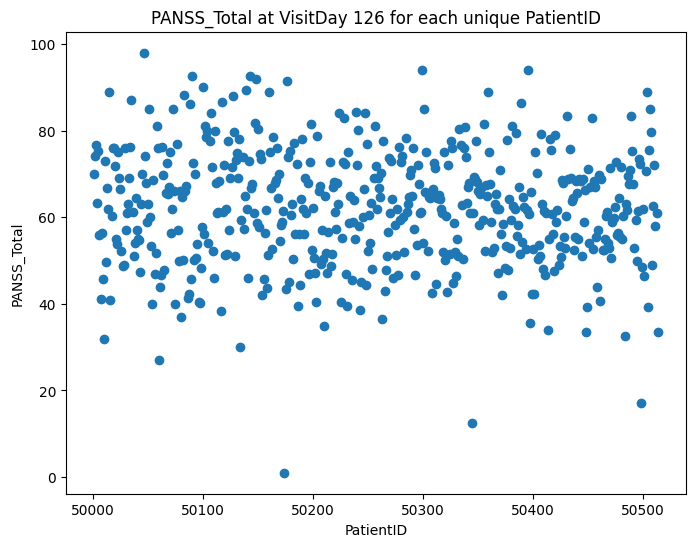

In [118]:
# plot the predicted PANSS_Total at VisitDay 126 for each unique PatientID
plt.figure(figsize=(8, 6))
plt.scatter(df_predict['PatientID'], df_predict['PANSS_Total'])
plt.xlabel('PatientID')
plt.ylabel('PANSS_Total')
plt.title('PANSS_Total at VisitDay 126 for each unique PatientID')
plt.show()

In [100]:
df_predict.to_csv('Forecasting.csv', index=False)

# --------------------------------------------------------

### Second Trial of the Forecasting with VisitDay, TxGroup, G_Total and PANSS_Total_Diff as the Feature. 
## Kaggle Public Score: 87.75881

In [108]:
def mul_linear_regression(df):
    X = df[['VisitDay', 'TxGroup', 'G_Total', 'PANSS_Total_Diff']]
    y = df['PANSS_Total']
    model = LinearRegression()
    model.fit(X, y)
    return model

# the G_Total in predicting the PANSS_Total for VisitDay 126 use the mean of G_Total for each unique PatientID
def mul_predict(df):
    model = mul_linear_regression(df)
    return model.predict([[126, df['TxGroup'].mean(), df['G_Total'].mean(), df['PANSS_Total_Diff'].mean()]])

In [109]:
# create a dataframe to store the predicted PANSS_Total at VisitDay 126 for each unique PatientID
df_predict = pd.DataFrame(columns=['PatientID', 'PANSS_Total'])
df_predict['PatientID'] = df['PatientID']
df_predict['PANSS_Total'] = df_predict['PatientID'].apply(lambda x: mul_predict(df[df['PatientID'] == x]))

In [110]:
df_predict.drop_duplicates(subset='PatientID', keep='first', inplace=True)
df_predict['PANSS_Total'] = df_predict['PANSS_Total'].apply(lambda x: x[0])
df_predict

,PatientID,PANSS_Total
0,50001,70.000000
1,50002,73.993038
5,50003,78.370379
10,50004,64.191691
15,50005,77.902918
...,...,...
1948,50509,62.815243
1953,50510,72.000000
1954,50511,58.000000
1955,50512,67.439771


In [111]:
df_predict.to_csv('Forecasting_mul.csv', index=False)

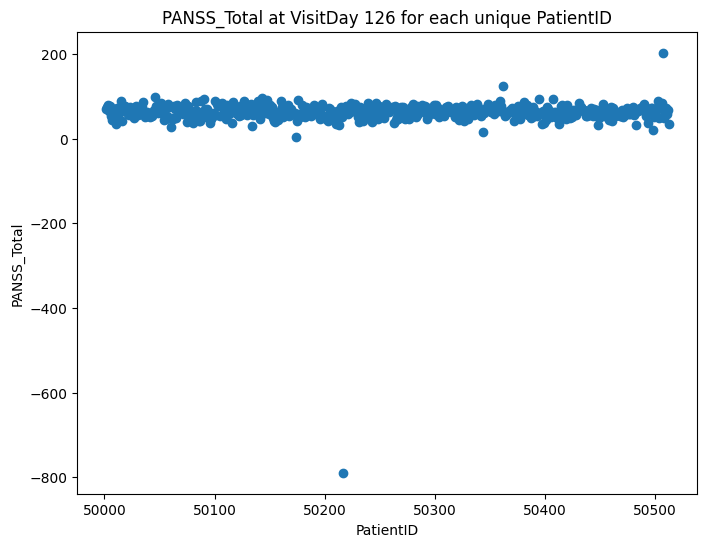

In [112]:
# plot the predicted PANSS_Total at VisitDay 126 for each unique PatientID
plt.figure(figsize=(8, 6))
plt.scatter(df_predict['PatientID'], df_predict['PANSS_Total'])
plt.xlabel('PatientID')
plt.ylabel('PANSS_Total')
plt.title('PANSS_Total at VisitDay 126 for each unique PatientID')
plt.show()

### Third Trial of the Forecasting with VisitDay, TxGroup, G_Total and PANSS_Total_Diff as the Feature. 
### Using Random Forest Regressor
## Kaggle Public Score: 7.0229

In [119]:
# import random forest regressor
from sklearn.ensemble import RandomForestRegressor

def mul_random_forest_regression(df):
    X = df[['VisitDay', 'TxGroup', 'G_Total', 'PANSS_Total_Diff']]
    y = df['PANSS_Total']
    model = RandomForestRegressor()
    model.fit(X, y)
    return model

# the G_Total in predicting the PANSS_Total for VisitDay 126 use the mean of G_Total for each unique PatientID
def mul_random_forest_predict(df):
    model = mul_random_forest_regression(df)
    return model.predict([[126, df['TxGroup'].mean(), df['G_Total'].mean(), df['PANSS_Total_Diff'].mean()]])

# create a dataframe to store the predicted PANSS_Total at VisitDay 126 for each unique PatientID
df_predict = pd.DataFrame(columns=['PatientID', 'PANSS_Total'])
df_predict['PatientID'] = df['PatientID']
df_predict['PANSS_Total'] = df_predict['PatientID'].apply(lambda x: mul_random_forest_predict(df[df['PatientID'] == x]))

df_predict.drop_duplicates(subset='PatientID', keep='first', inplace=True)
df_predict['PANSS_Total'] = df_predict['PANSS_Total'].apply(lambda x: x[0])
df_predict

,PatientID,PANSS_Total
0,50001,70.00
1,50002,76.83
5,50003,78.95
10,50004,62.97
15,50005,80.76
...,...,...
1948,50509,64.12
1953,50510,72.00
1954,50511,58.00
1955,50512,62.30


In [120]:
df_predict.to_csv('Forecasting_random_forest.csv', index=False)

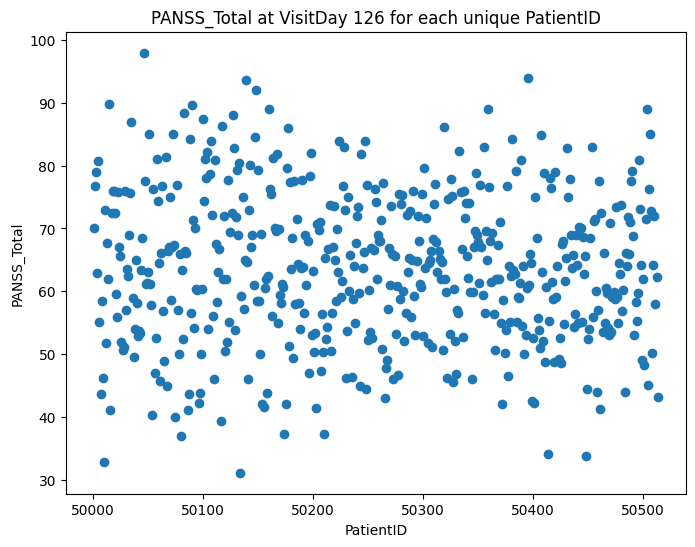

In [121]:
# plot the predicted PANSS_Total at VisitDay 126 for each unique PatientID
plt.figure(figsize=(8, 6))
plt.scatter(df_predict['PatientID'], df_predict['PANSS_Total'])
plt.xlabel('PatientID')
plt.ylabel('PANSS_Total')
plt.title('PANSS_Total at VisitDay 126 for each unique PatientID')
plt.show()

## Fourth Trial of the Forecasting with only VisitDay as the Feature. 
### Using Random Forest Regressor
## Kaggle Public Score: 6.64229

In [122]:
# import random forest regressor
from sklearn.ensemble import RandomForestRegressor

def mul_random_forest_regression(df):
    X = df[['VisitDay']]
    y = df['PANSS_Total']
    model = RandomForestRegressor()
    model.fit(X, y)
    return model

def mul_random_forest_predict(df):
    model = mul_random_forest_regression(df)
    return model.predict([[126]])

df_predict = pd.DataFrame(columns=['PatientID', 'PANSS_Total'])
df_predict['PatientID'] = df['PatientID']
df_predict['PANSS_Total'] = df_predict['PatientID'].apply(lambda x: mul_random_forest_predict(df[df['PatientID'] == x]))

df_predict.drop_duplicates(subset='PatientID', keep='first', inplace=True)
df_predict['PANSS_Total'] = df_predict['PANSS_Total'].apply(lambda x: x[0])
df_predict

,PatientID,PANSS_Total
0,50001,70.00
1,50002,75.83
5,50003,78.54
10,50004,63.04
15,50005,77.94
...,...,...
1948,50509,63.52
1953,50510,72.00
1954,50511,58.00
1955,50512,59.33


In [123]:
df_predict.to_csv('Single_Forecasting_random_forest.csv', index=False)

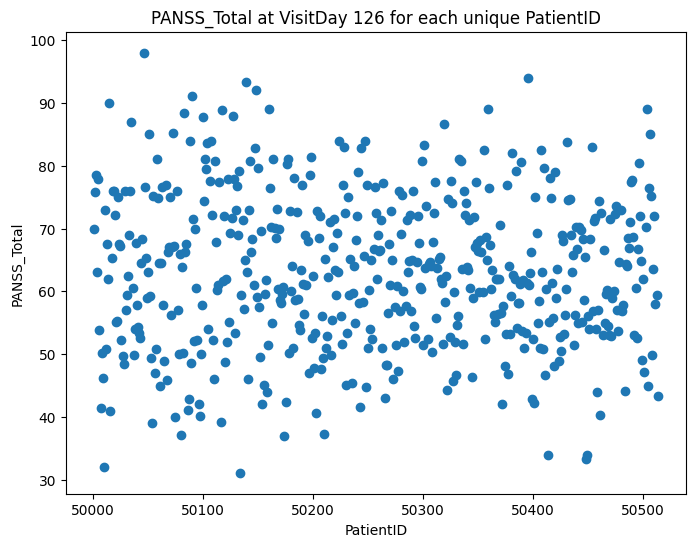

In [124]:
# plot the predicted PANSS_Total at VisitDay 126 for each unique PatientID
plt.figure(figsize=(8, 6))
plt.scatter(df_predict['PatientID'], df_predict['PANSS_Total'])
plt.xlabel('PatientID')
plt.ylabel('PANSS_Total')
plt.title('PANSS_Total at VisitDay 126 for each unique PatientID')
plt.show()

### Sample Submission, Kaggle Public Score: 25.07851

In [126]:
ttt = pd.read_csv('sample_submission_PANSS.csv')
ttt.to_csv('sample_submission_PANSS.csv', index=False)

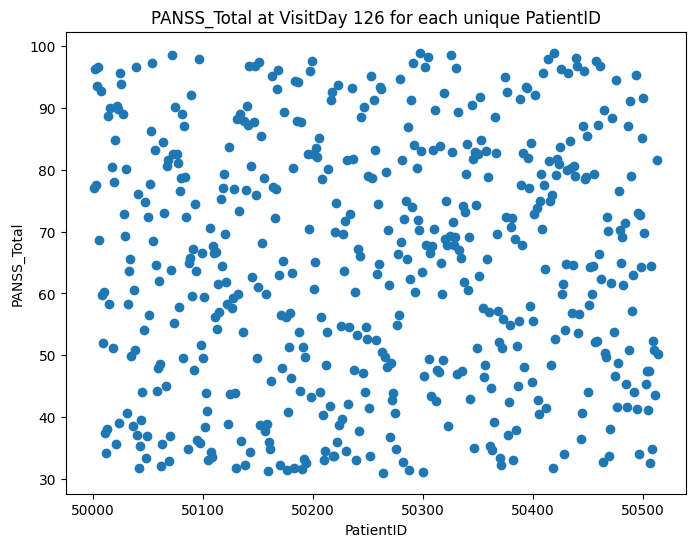

In [129]:
plt.figure(figsize=(8, 6))
plt.scatter(ttt['PatientID'], ttt['PANSS_Total'])
plt.xlabel('PatientID')
plt.ylabel('PANSS_Total')
plt.title('PANSS_Total at VisitDay 126 for each unique PatientID')
plt.show()